# Исправление опечаток

In [1]:
import gc
import glob

import pandas as pd
import spacy
from pandarallel import pandarallel
from spacymoji import Emoji
from symspellpy import SymSpell, Verbosity
from tqdm import tqdm

pandarallel.initialize(progress_bar=True)
tqdm.pandas()

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


Для исправления опечаток в тексте будем использовать SymSpell, т.к. он довольно быстрый и поддерживает большие словари (как, например, `frequency_dictionary_en_82_765`, который будет использоваться).

Токены, не являющиеся словами, будем оставлять как есть, слово с опечаткой будет заменяться на самый частотный вариант.

In [2]:
class CorrectedWordsCounter:
    def __init__(self):
        self.corrected = 0
        
    def update(self, corrected):
        self.corrected += corrected

In [3]:
class TypoCorrector:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
        self.sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
        self.sym_spell.load_dictionary('frequency_dictionary_en_82_765.txt', encoding='utf-8-sig', term_index=0, count_index=1)
    
    def process_text(self, text: str):
        doc = self.nlp(text)
        tokens = []
        corrected_cnt = 0
        for token in doc:
            if not token.is_alpha:
                tokens.append(token.text)
                continue

            lemma = token.lemma_.lower()
            suggestions = self.sym_spell.lookup(lemma, Verbosity.TOP)
            if suggestions and suggestions[0].term != lemma:
                tokens.append(suggestions[0].term)
                corrected_cnt += 1
            else:
                tokens.append(lemma)
        
        return ' '.join(tokens), {'corrected': corrected_cnt}

In [ ]:
total_rows = pd.read_csv('/Users/lev_k/HSE/YP/modified_train.csv', index_col=0).shape[0]
gc.collect()

total_stats = CorrectedWordsCounter()
processor = TypoCorrector()
reader = pd.read_csv('/Users/lev_k/HSE/YP/modified_train.csv', chunksize=100000)
with tqdm(total=total_rows, desc="Processing") as pbar:
    for i, chunk in enumerate(reader):
        results = chunk.parallel_apply(
            lambda row: processor.process_text(row['comment_text']), 
            axis=1,
            result_type='expand'
        )
        
        # Обновляем статистику
        chunk_stats = results[1].apply(pd.Series).sum()
        total_stats.update(chunk_stats['corrected'])
        
        # Сохраняем результаты
        chunk['corrected_ct'] = results[0]
        chunk['corrected'] = results[1].apply(lambda stats: stats['corrected'])
        
        chunk.to_parquet(f'processed_chunk_{i}.parquet', index=False)

        pbar.update(len(chunk))

        del chunk, results
        gc.collect()

In [5]:
print(f"""
Статистика обработки:
- Исправленных слов: {total_stats.corrected}
""")


Статистика обработки:
- Исправленных слов: 1755843



In [6]:
processed_df = pd.concat(
    [pd.read_parquet(f, engine='pyarrow') for f in glob.glob('processed_chunk_*.parquet')],
    ignore_index=False
)
processed_df.set_index('id', inplace=True)

In [7]:
processed_df['corrected_ct'] = processed_df['corrected_ct'].fillna('')

In [8]:
processed_df.to_csv('corrected_words_train.csv')

**Распределение опечаток**

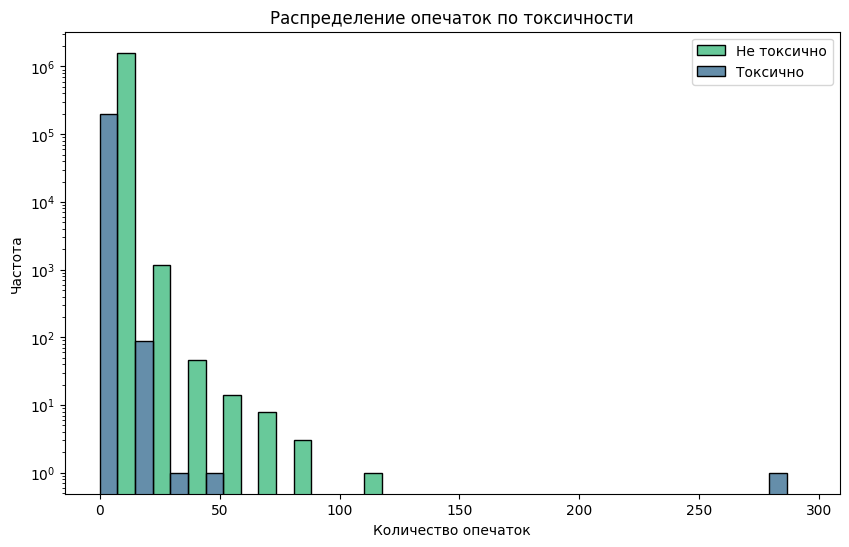

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(10, 6))
sns.histplot(data=processed_df, x='corrected', hue='toxicity_b', hue_order=[1, 0], kde=False, bins=20, palette="viridis", multiple="dodge")
plt.title('Распределение опечаток по токсичности')
plt.xlabel('Количество опечаток')
plt.ylabel('Частота')
plt.legend(labels=['Не токсично', 'Токсично'])
plt.yscale('log')
plt.show()

**Тест на равенство средних опечаток в токсичных и нетоксичных коментариях**

In [10]:
from scipy.stats import ttest_ind

group_0 = processed_df[processed_df['toxicity_b'] == 0]['corrected']
group_1 = processed_df[processed_df['toxicity_b'] == 1]['corrected']

ttest_ind(group_0, group_1, equal_var=False)

TtestResult(statistic=-5.889681100306851, pvalue=3.874316409834461e-09, df=251184.8215992906)

По результатам статистического теста на равенство средних видно, что средние значения для исправленных опечаток различаются, в токсичных комментариях их больше. Возможно в пылу гнева агрессивные комментаторы промахиваются по клавишам)

Теперь сравним качество модели, обученной на просто лемматизированных текстах и текстах с исправленными опечатками. Для скорости будем обучать Логистическую регрессию с параметрами по умолчанию.

In [11]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_text(text):
    doc = nlp(text)
    tokens = []
    for token in doc:
        if token.is_alpha:
            tokens.append(token.lemma_.lower())
        else:
            tokens.append(token.text)
    return " ".join(tokens)

In [ ]:
total_rows = pd.read_csv('corrected_words_train.csv', index_col=0).shape[0]
gc.collect()

reader = pd.read_csv('corrected_words_train.csv', chunksize=100000)
with tqdm(total=total_rows, desc="Processing") as pbar:
    for i, chunk in enumerate(reader):
        chunk['tokenized_ct'] = chunk['comment_text'].parallel_apply(tokenize_text)
        chunk.to_parquet(f'tokenized_chunk_{i}.parquet', index=False)
        pbar.update(len(chunk))

        del chunk
        gc.collect()

In [13]:
processed_df = pd.concat(
    [pd.read_parquet(f, engine='pyarrow') for f in glob.glob('tokenized_chunk_*.parquet')],
    ignore_index=False
)
processed_df.set_index('id', inplace=True)

In [14]:
processed_df['tokenized_ct'] = processed_df['tokenized_ct'].fillna('')

In [15]:
processed_df.to_csv('corrected_and_tokenized_words_train.csv')

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_bows(X_train, X_test):
    vectorizer = CountVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)


def get_tfidf(X_train, X_test):
    vectorizer = TfidfVectorizer()
    return vectorizer.fit_transform(X_train), vectorizer.transform(X_test)

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(processed_df['tokenized_ct'], processed_df['toxicity_b'], test_size=0.2, random_state=42)
X_train_corrected, X_test_corrected, y_train_corrected, y_test_corrected = train_test_split(processed_df['corrected_ct'], processed_df['toxicity_b'], test_size=0.2, random_state=42)
    

In [18]:
X_train_bows, X_test_bows = get_bows(X_train, X_test)
X_train_tfidf, X_test_tfidf = get_tfidf(X_train, X_test)

X_train_bows_corrected, X_test_bows_corrected = get_bows(X_train_corrected, X_test_corrected)
X_train_tfidf_corrected, X_test_tfidf_corrected = get_tfidf(X_train_corrected, X_test_corrected)

In [ ]:
lr_bows = LogisticRegression(random_state=42, max_iter=1000)
lr_bows.fit(X_train_bows, y_train)

lr_bows_corrected = LogisticRegression(random_state=42, max_iter=1000)
lr_bows_corrected.fit(X_train_bows_corrected, y_train_corrected)

In [20]:
print("Default tokenized BOWs F1-score:", f1_score(y_test, lr_bows.predict(X_test_bows)))
print("Corrected tokenized BOWs F1-score:", f1_score(y_test_corrected, lr_bows_corrected.predict(X_test_bows_corrected)))

Default tokenized BOWs F1-score: 0.5908750486803871
Corrected tokenized BOWs F1-score: 0.5868383920261792


In [ ]:
lr_tfidf = LogisticRegression(random_state=42, max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

lr_tfidf_corrected = LogisticRegression(random_state=42, max_iter=1000)
lr_tfidf_corrected.fit(X_train_tfidf_corrected, y_train_corrected)

In [22]:
print("Default tokenized TF-IDF F1-score:", f1_score(y_test, lr_tfidf.predict(X_test_tfidf)))
print("Corrected tokenized TF-IDF F1-score:", f1_score(y_test_corrected, lr_tfidf_corrected.predict(X_test_tfidf_corrected)))

Default tokenized TF-IDF F1-score: 0.6026466870726545
Corrected tokenized TF-IDF F1-score: 0.6027401417105402


Различия метрики F1 в пределах погрешности. Хотя исправление опечаток практичеки не влияет на качество модели, это нужно делать, чтобы уменьшить словарь при векторизации.